In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

%matplotlib inline

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Pre-Task: Describe the goals of your study

## Part 1: Aquire the Data

In [2]:
# psql -h dsi.c20gkj5cvu3l.us-east-1.rds.amazonaws.com -p 5432 -U dsi_student titanic
# password: gastudents

# #do this code in the command line. DONE 10-3-16 

#### 1. Connect to the remote database

#### 2. Query the database and aggregate the data

In [3]:
from pandas.io import sql
import sqlite3
sqlite_db = 'my_first_db.sqlite'
conn = sqlite3.connect(sqlite_db)

pd.read_csv('TITANIC2.csv').to_sql('TITANIC2',con=conn,if_exists='replace',index=False)

In [4]:
sql.read_sql('SELECT * FROM TITANIC2 limit 5', con=conn)

,index,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


In [5]:
titanic_df = sql.read_sql('SELECT * FROM TITANIC2', con=conn)

In [6]:
#DELETING THE ADDITIONAL INDEX COLUMN PRODUCED WHEN READING IN THE DATA
del titanic_df['index']

In [7]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,None,S


## Part 2: Exploratory Data Analysis

#### 1. Describe the Data

In [8]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [9]:
#I DECIDED TO TAKE THE TITLES FROM EACH PASSENGER AND CREATE LIST FEATURE CALLED TITLE TO RUN REGRESSION
titanic_df.Name = titanic_df.Name.apply(lambda x: x.split(',')[1].split('.')[0])


In [10]:
titanic_df.Name.nunique()

17

In [11]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [12]:
#FILLING THE NAN VALUES IN THE AGE COLUMN WITH THE AVERAGE AGE OF THE PASSENGERS 
titanic_df.Age = titanic_df.Age.fillna(titanic_df.Age.mean())

#### 2. Visualize the Data

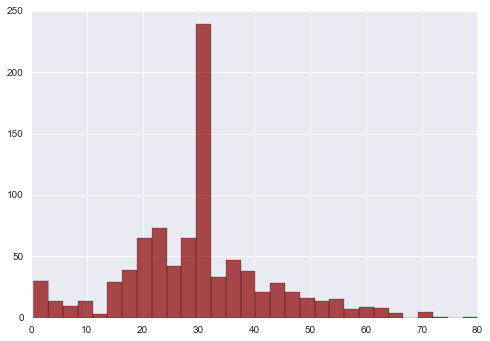

In [13]:
#IMPORTING SEABORN AND INCLUDING A HISTOGRAM OF THE AGE COLUMN.  I SEE THERE IS A HUGE BUCKET BETWEEN 20 AND 40 MEANING 
#A VERY LARGE POPULATION WERE YOUNGER.  
import seaborn as sns

titanic_df['Age'].hist(bins=30,color='darkred',alpha=0.7)

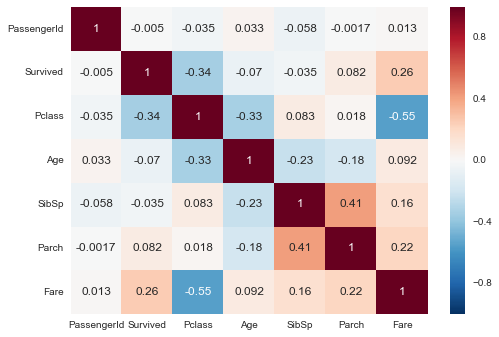

In [14]:
#VIEWING A HEAT MAP CHART OF THE NUMBERIC FEATURES.  PARCH AND FARE ARE THE TWO MOST CORRELATED FEATURES.  
sns.heatmap(titanic_df.corr(),annot=True) 

In [15]:
#USING .CORR() SIMPLY MIRRORS THE HEATMAP SHOWN ABOVE.  THE NUMBERS ARE EASIER TO READ FOR MOST 
titanic_df.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.033207,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.069809,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.331339,0.083081,0.018443,-0.549500
Age,0.033207,-0.069809,-0.331339,1.000000,-0.232625,-0.179191,0.091566
SibSp,-0.057527,-0.035322,0.083081,-0.232625,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.179191,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.091566,0.159651,0.216225,1.000000


In [16]:
#Here I am plotting or graphing Survived vs. Lost 

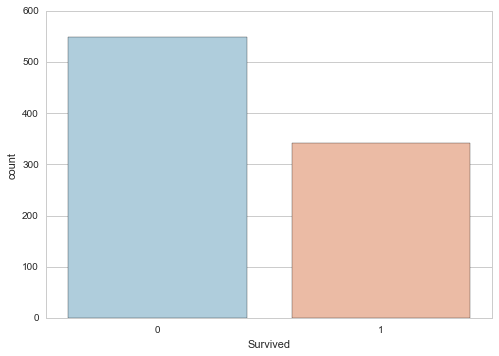

In [17]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=titanic_df,palette='RdBu_r')

In [18]:
#This graph shows the breakdown of Survived via Sex.  We see that males on average did not do so well surviving the 
#titanic.  

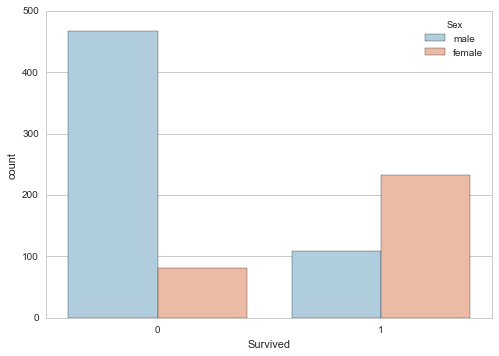

In [19]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=titanic_df,palette='RdBu_r')

In [20]:
#Plot featuring how ones Pclass affected their Survivial rate.  For the Lost group the majority of those from Pclass 3
#were lost. 

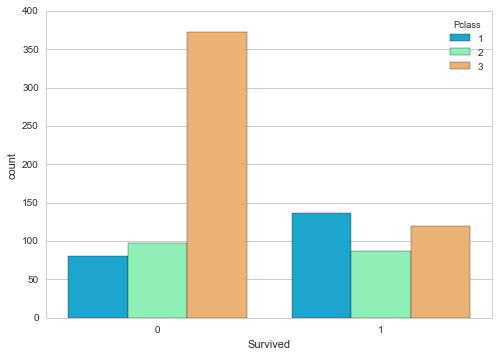

In [21]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=titanic_df,palette='rainbow')

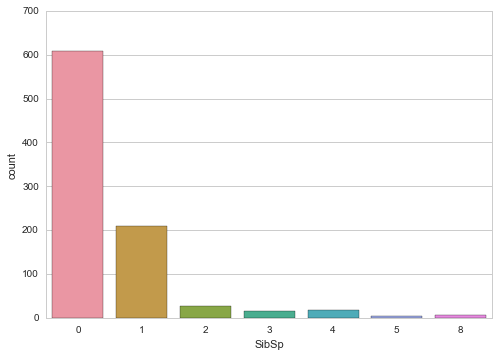

In [22]:
#I WANTED TO SHOW A PLOT OF THOSE SIBSP PASSENGERS AND WHAT THIS LEADS ME TO BELIEVE IS THAT THERE WERE A LOT OF SINGLE
#PASSENGES, COUPLED WITH THE AGE HISTOGRAPH SHOWN EARLIER I WOULD SUMMIZE THE MAJORITY WERE YOUNG SINGLE AND WITHOUT 
#CHILDREN. SOUNDS LIKE A SINGLES CRUISE TO ME 
sns.countplot(x='SibSp', data=titanic_df)

In [23]:
#I AM CALLING THE FUNCTION PREPROCESSING FROM SKLEARN IN ORDER TO PERFORM STANDARDIZATION ON THE AGE AND FAR FEATURES 

from sklearn import preprocessing
Age = titanic_df.Age
Fare = titanic_df.Fare

scaler = preprocessing.StandardScaler().fit(Age)
titanic_df.Age = scaler.transform(Age)

scaler = preprocessing.StandardScaler().fit(Fare)
titanic_df.Fare = scaler.transform(Fare)

//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.re

In [24]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,Mr,male,-0.592481,1,0,A/5 21171,-0.502445,None,S
1,2,1,1,Mrs,female,0.638789,1,0,PC 17599,0.786845,C85,C
2,3,1,3,Miss,female,-0.284663,0,0,STON/O2. 3101282,-0.488854,None,S
3,4,1,1,Mrs,female,0.407926,1,0,113803,0.420730,C123,S
4,5,0,3,Mr,male,0.407926,0,0,373450,-0.486337,None,S


## Part 3: Data Wrangling

#### 1. Create Dummy Variables for *Sex*  use sklearn pipline

In [25]:
#I AM CREATING DUMMIES VARIABLES AND SETTING EACH COLUMN TO 1'S AND 0'S.  SEX, PCLASS, NAME, AND EMBARKED WILL BEOME 
#CATEAGORIZED 
Sex = pd.get_dummies(titanic_df.Sex)

In [26]:
Pclass = pd.get_dummies(titanic_df.Pclass)
Name = pd.get_dummies(titanic_df.Name)
Embarked = pd.get_dummies(titanic_df.Embarked)

In [27]:
#DROPPING THE UNNESCCARY COLUMNS FROM MY ORIGNAL DATAFRAM TO REPLACE THEM WITH DUMMY VARIABLES I CREATED ABOVE. 
#ALSO I DECIDED TO DROP PASSENGERID AND CABIN.  EACH HAD A ERY LITTER COREELATION TO SURVIVAL RATE AND WERE UNECESSARY 
titanic_df.drop(['Pclass','Sex','Name','Embarked','PassengerId','Ticket','Cabin'], axis=1, inplace=True)

In [28]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
Survived    891 non-null int64
Age         891 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Fare        891 non-null float64
dtypes: float64(2), int64(3)
memory usage: 34.9 KB


In [29]:
#CONCATENING THE SEX, PCLASS, NAME, EMBAREKD CATEGORIES WITH MY ORIGANL 
titanic = pd.concat([titanic_df,Pclass,Sex,Name,Embarked],axis=1)

In [30]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 30 columns):
Survived         891 non-null int64
Age              891 non-null float64
SibSp            891 non-null int64
Parch            891 non-null int64
Fare             891 non-null float64
1                891 non-null float64
2                891 non-null float64
3                891 non-null float64
female           891 non-null float64
male             891 non-null float64
 Capt            891 non-null float64
 Col             891 non-null float64
 Don             891 non-null float64
 Dr              891 non-null float64
 Jonkheer        891 non-null float64
 Lady            891 non-null float64
 Major           891 non-null float64
 Master          891 non-null float64
 Miss            891 non-null float64
 Mlle            891 non-null float64
 Mme             891 non-null float64
 Mr              891 non-null float64
 Mrs             891 non-null float64
 Ms              891 non-nu

In [31]:
#PULLING OUT THE SURVIVED COLUMN.  THIS COLUMN WILL BECOME MY Y OR TARGET VARIBLE FOR MY REGRESSION. 
Survived = titanic.Survived

In [32]:
titanic.drop('Survived', axis=1,inplace=True)

## Part 4: Logistic Regression and Model Validation

#### 1. Define the variables that we will use in our classification analysis

In [33]:
#SETTING X VARIBLE TO TITANIC AND y TO SURVIVED FOR EASE OF REGRESSION

In [34]:
X = titanic
y = Survived

#### 2. Transform "Y" into a 1-Dimensional Array for SciKit-Learn

In [35]:
y.value_counts() / len(y) 
#Baseline..... Can my model beat this

0    0.616162
1    0.383838
Name: Survived, dtype: float64

#### 3. Conduct the logistic regression

In [36]:
#IMPORTING TRAIN_TEST_SPLIT, LOGISTICREGRESSION, CROSS_VALIDATION AND CROSS_VAL_SCORE FUNCTIONS FROM SKLEAN. 
#PERROMING THE TRAIN TEST SPLIT 

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=88)

In [37]:
logreg = LogisticRegression(penalty='l1')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
#AFTER PERFORMING THE LOGGREESSION I PRINT THE SCORE OF THE REGRESSION.  THE MODEL HAS AN 81.34 ACCURACY LETS SEE IF I 
#CAN TURN IT UP 
logreg.score(X_train, y_train)

0.8314606741573034

#### 4. Examine the coefficients

In [39]:
print logreg.intercept_

[ 0.]


In [40]:
#HERE, I AM LOOKING THOUGH SEVERAL FEATURES DETERMING WHICH I CAN POSSILBE REMOVE FOR MODEL PERFORANCE. I AM GOING TO 
#DROP ALL FEATURES THAT ARE ZERO'D OUT, DON, JONKHEER, LADY.  ALSO, I DECIDED TO DROP ALL NEGATIVE COLUMNS TO SEE IF 
#HELPS AS WELL. DROPPING AGE, SIBSP, PARCH, PCLASS 3, MALE, CAPTAIN, DR, MAJOR, MR, REVEREND, AND EMBARKED S. 
print logreg.coef_[0]

[-0.36072243 -0.34205918 -0.34614487  0.15177521  0.87422696  0.
 -1.19411039  2.13434672  0.          0.          0.          0.          0.
  0.          0.          0.          1.85837234  0.          0.          0.
 -0.83645801  0.47987035  0.          0.          0.          0.          0.
  0.         -0.35375563]


In [41]:
Coef_df = pd.DataFrame(logreg.coef_[0],X_train.columns,columns=['Coefficient'])


In [42]:
Coef_df

,Coefficient
Age,-0.360722
SibSp,-0.342059
Parch,-0.346145
Fare,0.151775
1,0.874227
2,0.000000
3,-1.194110
female,2.134347
male,0.000000
Capt,0.000000


In [43]:
X.columns

Index([          u'Age',         u'SibSp',         u'Parch',          u'Fare',
                      1,                2,                3,        u'female',
                u'male',         u' Capt',          u' Col',          u' Don',
                 u' Dr',     u' Jonkheer',         u' Lady',        u' Major',
             u' Master',         u' Miss',         u' Mlle',          u' Mme',
                 u' Mr',          u' Mrs',           u' Ms',          u' Rev',
                u' Sir', u' the Countess',             u'C',             u'Q',
                   u'S'],
      dtype='object')

In [44]:
#NOW LET US RUN REGRESSION AGAIN DROPPING THOSE COLUMNS.
X.drop(X.columns[[5,8,9,10,11,12,13,14,15,17,18,19,22,27]] ,axis=1, inplace=True)

In [45]:
X.head()

,Age,SibSp,Parch,Fare,1,3,female,Master,Mr,Mrs,Rev,Sir,the Countess,C,S
0,-0.592481,1,0,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.638789,1,0,0.786845,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.284663,0,0,-0.488854,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.407926,1,0,0.420730,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.407926,0,0,-0.486337,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [46]:
# PERFORMING A NEW TRAIN TEST SPLIT AND RUNNING A NEW LOGREGRESION WITH MY NEW LIST OF FEATURE.  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                                    random_state=88)

In [47]:
logreg = LogisticRegression(penalty='l1')
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [48]:
# I THINK I HAVE A GOOD MODEL.  NOT THE HIGHEST ACCURACY SCORE SO MORE TUNING. 
logreg.score(X_train, y_train)

0.8314606741573034

In [49]:
Coef_df = pd.DataFrame(logreg.coef_[0],X_train.columns,columns=['Coefficient'])

Coef_df

,Coefficient
Age,-0.360915
SibSp,-0.342135
Parch,-0.346147
Fare,0.151640
1,0.875797
3,-1.192623
female,2.131750
Master,1.855550
Mr,-0.838892
Mrs,0.480414


#### 6. Test on a *Test* 

In [50]:
#PREDICTING ONTO MY X_TEST

In [51]:
Y_pred = logreg.predict(X_test)
Y_pred

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1])

In [52]:
from sklearn import metrics

In [53]:
print('MAE:', metrics.mean_absolute_error(y_test, Y_pred))
print('MSE:', metrics.mean_squared_error(y_test, Y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, Y_pred)))

('MAE:', 0.18283582089552239)
('MSE:', 0.18283582089552239)
('RMSE:', 0.42759305524706831)


In [54]:
#NEED TO TUNE MY MODEL MORE.  I ONLY EXPLAIN ABOUT 17.8% OF THE VARIANCE OR NOISE 
metrics.explained_variance_score(y_test, Y_pred) 

0.19317972350230417

#### 7. Predict the class labels for the *Test* set

In [55]:
# ¯\_(ツ)_/¯ SHRUGGING HERE 

#### 8. Predict the class probabilities for the *Test* set

In [56]:
probability = logreg.predict_log_proba(X_test)

In [57]:
print (probability)

[[-1.0134065  -0.45095482]
 [-0.08371765 -2.52187222]
 [-1.15320887 -0.3792454 ]
 [-0.11744179 -2.19995875]
 [-0.11467482 -2.22244436]
 [-0.6417976  -0.74727695]
 [-0.3121866  -1.31618994]
 [-0.30743899 -1.32926293]
 [-0.54089597 -0.87281552]
 [-0.10057148 -2.34675086]
 [-2.66469033 -0.07216315]
 [-0.14134125 -2.02641647]
 [-0.19271305 -1.74136256]
 [-0.85847481 -0.5513143 ]
 [-0.08632502 -2.4924878 ]
 [-0.50752795 -0.92125772]
 [-0.79518102 -0.60056708]
 [-0.08276817 -2.53281033]
 [-0.48995147 -0.94844242]
 [-0.04773107 -3.06594339]
 [-0.10620752 -2.2949942 ]
 [-0.03997513 -3.23941878]
 [-0.55143869 -0.85830572]
 [-0.56621701 -0.83856347]
 [-0.11508208 -2.21909891]
 [-0.08330166 -2.52664849]
 [-1.19688819 -0.35972664]
 [-0.18927123 -1.75771764]
 [-0.5462801  -0.86536002]
 [-0.1656081  -1.87979268]
 [-0.10671499 -2.29047668]
 [-0.29650606 -1.36028018]
 [-0.08593809 -2.49678949]
 [-0.54058388 -0.87325063]
 [-0.82811715 -0.57424668]
 [-2.77586145 -0.06432072]
 [-0.21407767 -1.64654641]
 

#### 10. Cross validate on 10 folds

In [58]:
#FIRST, PRINTING INITIAL MODEL ACCURACY SCORE BEFORE CROSS-VALIDATION TO SEE THE COMPARISON. 
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score


print 'INITIAL MODEL ACCURACY (W/OUT Cross Validation: ',logreg.score(X_train, y_train),'\n'


scores = cross_validation.cross_val_score(logreg, X_train, y_train,scoring='accuracy', cv=10)
print'CV 10-FOLD SCORES: ', scores,'\n'

print'CV 10-FOLD MEAN ACCURACY', scores.mean(),'\n'

print'CV 10-FOLD STANDARD DEVIATION OF ACCURACY', scores.std(),'\n'

INITIAL MODEL ACCURACY (W/OUT Cross Validation:  0.831460674157 

CV 10-FOLD SCORES:  [ 0.84126984  0.79365079  0.79365079  0.80952381  0.77419355  0.83870968
  0.82258065  0.83870968  0.85483871  0.86885246] 

CV 10-FOLD MEAN ACCURACY 0.823597995518 

CV 10-FOLD STANDARD DEVIATION OF ACCURACY 0.0286819727156 



#### 11. Check the Classification Report

In [59]:
#LOGREGESSION WITH CLASSIFICATION REPORT AND CONFUSION MATRIX.  

from sklearn.metrics import classification_report

print(classification_report(y_test,Y_pred))

             precision    recall  f1-score   support

          0       0.86      0.86      0.86       175
          1       0.73      0.74      0.74        93

avg / total       0.82      0.82      0.82       268



#### 12. What do the classification metrics tell us?

#### 13. Check the Confusion Matrix

In [60]:
from sklearn.metrics import confusion_matrix

In [61]:
conmat = np.array(confusion_matrix(y_test, Y_pred, labels=[1,0]))

confusion = pd.crosstab(y_test, Y_pred, rownames=['ACTUAL'], colnames=['PREDICTED'], margins=True)

In [62]:
print confusion

PREDICTED    0   1  All
ACTUAL                 
0          150  25  175
1           24  69   93
All        174  94  268


In [63]:
print (confusion_matrix(y_test, Y_pred)) 

[[150  25]
 [ 24  69]]


In [64]:
#TOTAL = 268
#should read TN = 150 , FN = 24, FP = 25 and TP = 69
#Total Predicted Survived 94  (FP+TP)
#Total Predicted Lost 174  (TN+FN)
#Actual Lost 175 (TN+FP)
#Actual Survived 93 (FN+TP)

#ACCURACY = TP+TN / 268 OR (150+69)/268 OR 82%
#Total Survived predicted rate = TP/(FN+TP) OR 70/(23+70) OR 73% 

#Total Lost predicted rate = FP / (TN+FP) or 25/(150+24) OR 14.4%

#### 14. What does the Confusion Matrix tell us? 

In [65]:
#SEE ABOVE BOX

#### 15. Plot the ROC curve

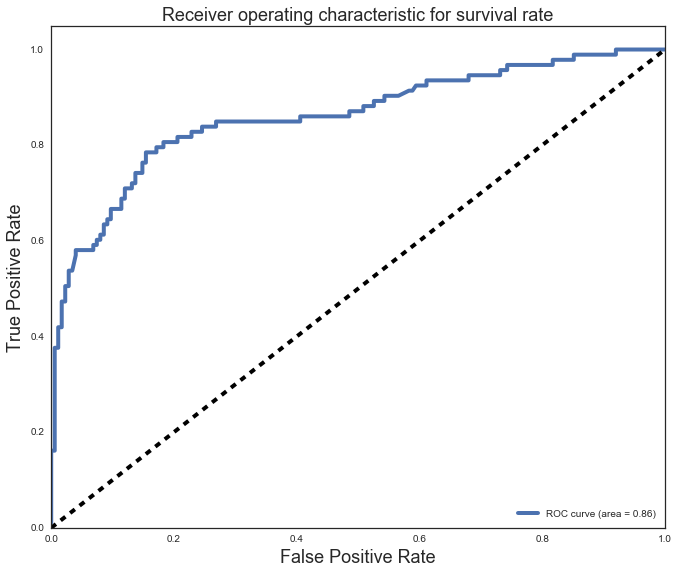

In [66]:
from sklearn.metrics import roc_curve, auc
plt.style.use('seaborn-white')

Y_score = logreg.decision_function(X_test)

FPR = dict()
TPR = dict()
ROC_AUC = dict()

# For class 1, find the area under the curve
FPR[1], TPR[1], _ = roc_curve(y_test, Y_score)
ROC_AUC[1] = auc(FPR[1], TPR[1])


plt.figure(figsize=[11,9])
plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic for survival rate', fontsize=18)
plt.legend(loc="lower right")
plt.show()

#### 16. What does the ROC curve tell us?

In [67]:
#  ¯\_(ツ)_/¯

## Part 5: Gridsearch

#### 1. Use GridSearchCV with logistic regression to search for optimal parameters 

- Use the provided parameter grid. Feel free to add if you like (such as n_jobs).
- Use 5-fold cross-validation.

In [68]:
from sklearn.grid_search import GridSearchCV

logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}

log_gs = GridSearchCV(LogisticRegression(), logreg_parameters, cv=5, verbose=1)
log_gs.fit(X_train, y_train)

//anaconda/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.2s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [69]:
#Optimal Logoist Grid Search regression for C = 1.38945
log_gs.predict(X_test)

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1])

#### 2. Print out the best parameters and best score. Are they better than the vanilla logistic regression?

In [70]:
print('GRID SEARCH BEST SCORE: %.4f' % log_gs.best_score_)
print('GRID SEARCH BEST PARAMER FOR LOGRED: ')
print log_gs.best_params_

GRID SEARCH BEST SCORE: 0.8283
GRID SEARCH BEST PARAMER FOR LOGRED: 
{'penalty': 'l2', 'C': 0.19306977288832497, 'solver': 'liblinear'}


In [71]:
#THE SCORE DOESN'T SEEM TO BE BETTER THAN MY VANILLA LOGISTIC REGRESSION.  ALTHOUGH I DO HAVE AN OPTIMIZED ALPHA OR C 
#WHICH TO TAKE INTO CONSIDERATION WHEN CHANGING MY MODEL 

#### 3. Explain the difference between the difference between the L1 (Lasso) and L2 (Ridge) penalties on the model coefficients.

In [72]:
#NO NEED TO RUN LOGREG WITH L2, L2 IS DEFAULT.  WHERE C IS THE ALPHA 
#take what we did in class for here... logreg_coef_jason 10-7-16
#see how are coefficients change here when we use LassoCV and RidgeCV 

#### 4. What hypothetical situations are the Ridge and Lasso penalties useful?

In [73]:
# ¯\_(ツ)_/¯ 

#### 5. Explain how the regularization strength (C) modifies the regression loss function. Why do the Ridge and Lasso penalties have their respective effects on the coefficients?

In [74]:
#C = alpha, logregression choses alpha = 1, 

#### 6.a. You decide that you want to minimize false positives. Use the predicted probabilities from the model to set your threshold for labeling the positive class to need at least 90% confidence. How and why does this affect your confusion matrix?

In [75]:
Y_pred_log_gs = log_gs.predict_proba(X_test)

In [76]:
#SETTING THE THRESHOLD T 90% CREATING VARIABLE Y_PRED_THRESH 
Y_pred_thresh = [1 if x <= 0.10 else 0 for x in Y_pred_log_gs.T[0]]

In [77]:
#HOW THIS EXPLAINS THE CONFUSION MATRIX.  FIRST CREATING CONFUSION MATRIX FOR NEW Y_PRED_LOG_GS AND WILL COMPARE IT 
#WITH THE CONFUSION MATRIX FOR Y_PRED

In [78]:
print(confusion_matrix(y_test ,Y_pred_thresh))

[[174   1]
 [ 74  19]]


In [79]:
#A REDUNDANT MORE READER FRIENDLY VERSION OF THE CONFUSION MATRIX USING MY ORIGINAL Y_PRED WITHOUT CHANGING THE 
#THRESHOLD 
print confusion

PREDICTED    0   1  All
ACTUAL                 
0          150  25  175
1           24  69   93
All        174  94  268


In [80]:
print (confusion_matrix(y_test, Y_pred))

[[150  25]
 [ 24  69]]


In [81]:
#COMPARING CONFUSION MATRIX FROM Y_PRED AND Y_PRED_THRESH.  WE SET THE THRESHOLD OF PREDICTION TO 90% IN ORDER TO 
#DECREASE THE AMOUNT OF FALSE POSITIVES.  COMPARING EACH CONFUSION MATRIX.  Y_PRED_THRESH HAS DROPPED THE NUMBER 
#OF FALSE POSITIVES TO 1.  

#SINCE THERE ARE FEWER FALSE POSITIVES, ONLY PREDICTING ONE SURVIVAL INCORRECTLY MY ACCURACY CHANGES.  THE ACCURACY 
#FOR THE Y_PRED_THRESH IS 73.88% WHILE THE ACCURACY FROM Y_PRED IS 81.71%.  

#ALSO, COMPARING THE MISCLASSIFICATION RATES, THE Y_PRED_THRESH YIELDS 26.11% WHILE THE Y_PRED MISCLASSIFICATION RATE 
#18.65%.  MEANING WITH THE THRESHOLD OF 90% I AM COMPLETELY GETTING THIS WRONG.  IT IS BEST NOT TO USE SUCH A HIGH 
#THRESHOLD HERE.  

## Part 6: Gridsearch and kNN

#### 1. Perform Gridsearch for the same classification problem as above, but use KNeighborsClassifier as your estimator

At least have number of neighbors and weights in your parameters dictionary.

In [82]:
from sklearn.neighbors import KNeighborsClassifier

In [83]:
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn_params = {
    'n_neighbors':range(5,20),
    'weights':['distance','uniform']
}

knn_gs = GridSearchCV(KNeighborsClassifier(), knn_params, cv=5, verbose=1)
knn_gs.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    1.8s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'weights': ['distance', 'uniform']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

#### 2. Print the best parameters and score for the gridsearched kNN model. How does it compare to the logistic regression model?

In [84]:
print('Grid Search Best Score: %.4f' % knn_gs.best_score_)
print('Grid Search Best Parameter for C: ')
print knn_gs.best_params_

Grid Search Best Score: 0.8234
Grid Search Best Parameter for C: 
{'n_neighbors': 10, 'weights': 'distance'}


In [85]:
#THE ACCURACY FOR MY GRID SEARCH LOGREGRESSION IS:
print('LogReg Grid Search Best Score: %.4f' % log_gs.best_score_)

LogReg Grid Search Best Score: 0.8283


In [86]:
#WHILE THE KNN GRIDSEARCH SCORE IS
print('KNN Grid Search Best Score: %.4f' % knn_gs.best_score_)

KNN Grid Search Best Score: 0.8234


In [87]:
#THE SCORES ARE THE SAME ROUGHLY 82.66% FOR LOGREG VS. 82.34% FOR KNN.  CHOOSING TO GRIDSEARCH, 
#REGARDLESS OF THE TYPE OF ESTIMATOR I USED, KNN OR LOGREG, YEILD THE SAME RESULTS.  

#### 3. How does the number of neighbors affect the bias-variance tradeoff of your model?

#### Why?

In [88]:
#CHANGED NUMBER OF NEIGHBORS FROM 5-20 TO 5-100 AND GRID SEARCH STILL CHOSE OPTIMAL NUMBER OF 19 


knn_params_NEW = {
    'n_neighbors':range(5,100),
    'weights':['distance','uniform']
}

knn_gs_NEW = GridSearchCV(KNeighborsClassifier(), knn_params, cv=19, verbose=1)
knn_gs_NEW.fit(X_train, y_train)

Fitting 19 folds for each of 30 candidates, totalling 570 fits


[Parallel(n_jobs=1)]: Done 570 out of 570 | elapsed:    5.7s finished


GridSearchCV(cv=19, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19], 'weights': ['distance', 'uniform']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [89]:
print('Grid Search Best Score: %.4f' % knn_gs_NEW.best_score_)
print('Grid Search Best Parameter for KN: ')
print knn_gs_NEW.best_params_

Grid Search Best Score: 0.8250
Grid Search Best Parameter for KN: 
{'n_neighbors': 9, 'weights': 'uniform'}


In [90]:
#CHANGING THE NUMBER OF NEIGHBORS DOES NOT SEE TO EFFECT THE ACCURACY OF THE GRIDSEARCH.  WHY, I BELIEVE IT IS DO TO THE FUNCTION 
#GRIDSEARCH.  GRIDSEARCH SEARCHS FOR OPTIMAL CONDITIONS, AND FOR THE KNN IS BASED THE WEIGHT, OR VOTE OF EACH 
#FEATURE UNIFORMLY AND NOT BY DISTANCE.  THERE IS ONE THING I NOTICED. CHANGING THE NUMBER OF NEIGHBORS DOES YIELD A 
#DIFFERENT OPTIMAL NEIGHBOR.  PREVIOUSLY IS WAS 19 NOW ITS 5.  HMMMMMM 

#### 4. In what hypothetical scenario(s) might you prefer logistic regression over kNN, aside from model performance metrics?

#### 5. Fit a new kNN model with the optimal parameters found in gridsearch. 

In [91]:
#FITTING A NEW KNN MODEL WITH N_NEIGHBORS SET TO OPTIMAL FROM MY PREVIOUS GRIDSEARCH(KNEIGHBORS) CLASSIFICATION
knn_opt = KNeighborsClassifier(n_neighbors=19)

In [92]:
knn_opt.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=19, p=2,
           weights='uniform')

In [93]:
Y_pred_knn = knn_opt.predict(X_test)
Y_pred_knn

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1])

In [94]:
# knn_opt.predict_proba(X_test)

In [95]:
logreg_opt = LogisticRegression(C=1.3894954943731359)
logreg_opt.fit(X_train, y_train)

LogisticRegression(C=1.38949549437, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [96]:
# logreg_opt.predict_proba(X_test)

In [97]:
Y_pred_log = logreg_opt.predict(X_test)
Y_pred_log

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1])

#### 6. Construct the confusion matrix for the optimal kNN model. Is it different from the logistic regression model? If so, how?

In [98]:
#CONFUSION MATRIX FEATURING OPTIMAL KNN VALUES 
conmat_knn = np.array(confusion_matrix(y_test, Y_pred_knn, labels=[1,0]))

confusionknn = pd.crosstab(y_test, Y_pred_knn, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [99]:
print confusionknn

Predicted    0   1  All
Actual                 
0          152  23  175
1           31  62   93
All        183  85  268


In [100]:
print(classification_report(y_test,Y_pred_knn))

             precision    recall  f1-score   support

          0       0.83      0.87      0.85       175
          1       0.73      0.67      0.70        93

avg / total       0.80      0.80      0.80       268



In [101]:
#CONFUSION MATRIX FOR OPTIMAL LOGREG VALUES 
conmat_log = np.array(confusion_matrix(y_test, Y_pred_log, labels=[1,0]))

confusionlog = pd.crosstab(y_test, Y_pred_log, rownames=['Actual'], colnames=['Predicted'], margins=True)

In [102]:
print confusionlog

Predicted    0   1  All
Actual                 
0          148  27  175
1           22  71   93
All        170  98  268


In [103]:
print(classification_report(y_test,Y_pred_log))

             precision    recall  f1-score   support

          0       0.87      0.85      0.86       175
          1       0.72      0.76      0.74        93

avg / total       0.82      0.82      0.82       268



In [104]:
#TO COMPARE THE TWO CONFUSION MATRICES ONE FROM OPTIMALL KNN AND THE OTHER FROM OPTIMAL LOGREG.  THE KNN DOES YEILD
#THE BETTER ACCURACY.  WHAT I FIND MOST INTERESTING IS MY OPTIMAL LOG MATRIX HAS A HIGHER PRECISION WHEN PREDICTING 
#SURVIVAL COUPLED WITH A LOWER PECISION PREDICTING LOST.  ON THE OTHER HAND THE KNN OPTIMAL MATRIX YEILDS THE 
#OPPOSITE.  IT SEEMS THAT KNN MODEL CHOSES LOST MORE PRECISELY THAN MY LOGREG, BUT PREDICTS SURVIVAL LESS. 

#### 7. Plot the ROC curves for the optimized logistic regression model and the optimized kNN model on the same plot.

In [105]:
#optimized parametes from gridsearch(logreg) - {'penalty': 'l2', 'C': 1.3894954943731359, 'solver': 'liblinear'}

In [106]:
# from sklearn.metrics import roc_curve, auc
# plt.style.use('seaborn-white')

# Y_score = logreg.decision_function(X_test)

# FPR = dict()
# TPR = dict()
# ROC_AUC = dict()

# # For class 1, find the area under the curve
# FPR[1], TPR[1], _ = roc_curve(y_test, Y_score)
# ROC_AUC[1] = auc(FPR[1], TPR[1])


# plt.figure(figsize=[11,9])
# plt.plot(FPR[1], TPR[1], label='ROC curve (area = %0.2f)' % ROC_AUC[1], linewidth=4)
# plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate', fontsize=18)
# plt.ylabel('True Positive Rate', fontsize=18)
# plt.title('Receiver operating characteristic for survival rate', fontsize=18)
# plt.legend(loc="lower right")
# plt.show()

## Part 7: Precision-recall

#### 1. Gridsearch the same parameters for logistic regression but change the scoring function to 'average_precision'

`'average_precision'` will optimize parameters for area under the precision-recall curve instead of for accuracy.

In [107]:
logreg_parameters = {
    'penalty':['l1','l2'],
    'C':np.logspace(-5,1,50),
    'solver':['liblinear']
}

log_gs = GridSearchCV(LogisticRegression(), logreg_parameters, cv=5, verbose=1)
log_gs.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:    4.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'penalty': ['l1', 'l2'], 'C': array([  1.00000e-05,   1.32571e-05,   1.75751e-05,   2.32995e-05,
         3.08884e-05,   4.09492e-05,   5.42868e-05,   7.19686e-05,
         9.54095e-05,   1.26486e-04,   1.67683e-04,   2.22300e-04,
         2.94705e-04,   3.90694e-04,   5.17947e-04,   6.8...6e+00,   4.29193e+00,   5.68987e+00,
         7.54312e+00,   1.00000e+01]), 'solver': ['liblinear']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=1)

In [108]:
from sklearn.metrics import (precision_recall_curve, average_precision_score, f1_score)


def plot_prauc(mod, X_train, y_train, varname):
    mod.fit(X, y)
    y_pp = mod.predict_proba(X)[:, 1]
    precision, recall, _ = precision_recall_curve(y, y_pp)
    avg_precision = average_precision_score(y, y_pp)
    
    fig, axr = plt.subplots(figsize=(8,7))

    axr.plot(recall, precision, label='PRAUC (area = %0.2f)' % avg_precision,
             color='steelblue', linewidth=4,
             alpha=0.7)

    axr.set_xlim([-0.05, 1.05])
    axr.set_ylim([0.0, 1.05])
    axr.set_xlabel('recall', fontsize=16)
    axr.set_ylabel('precision', fontsize=16)
    axr.set_title(varname+' vs. not PRAUC curve\n', fontsize=20)

    axr.legend(loc="upper right", fontsize=12)

    plt.show()

#### 2. Examine the best parameters and score. Are they different than the logistic regression gridsearch in part 5?

#### 3. Create the confusion matrix. Is it different than when you optimized for the accuracy? If so, why would this be?

#### 4. Plot the precision-recall curve. What does this tell us as opposed to the ROC curve?

[See the sklearn plotting example here.](http://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html)

Automatically created module for IPython interactive environment


//anaconda/lib/python2.7/site-packages/sklearn/multiclass.py:76: UserWarning: Label not 2 is present in all training examples.
  str(classes[c]))


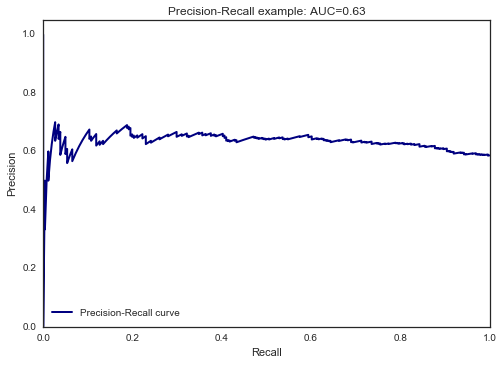

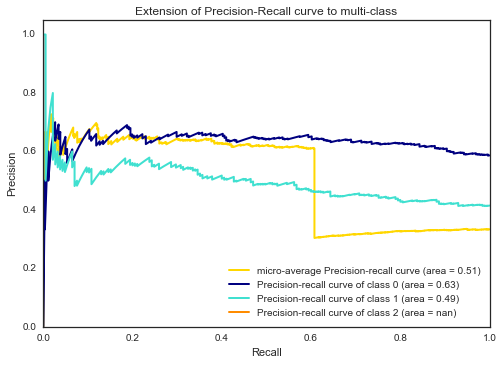

In [109]:
print(__doc__)

import matplotlib.pyplot as plt
import numpy as np
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
lw = 2

# Binarize the output
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

# Add noisy features
random_state = np.random.RandomState(0)
n_samples, n_features = X.shape
X = np.c_[X, random_state.randn(n_samples, 200 * n_features)]

# Split into training and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5,
                                                    random_state=random_state)

# Run classifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=random_state))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute Precision-Recall and plot curve
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

# Compute micro-average ROC curve and ROC area
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")


# Plot Precision-Recall curve
plt.clf()
plt.plot(recall[0], precision[0], lw=lw, color='navy',
         label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall example: AUC={0:0.2f}'.format(average_precision[0]))
plt.legend(loc="lower left")
plt.show()

# Plot Precision-Recall curve for each class
plt.clf()
plt.plot(recall["micro"], precision["micro"], color='gold', lw=lw,
         label='micro-average Precision-recall curve (area = {0:0.2f})'
               ''.format(average_precision["micro"]))
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=lw,
             label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(i, average_precision[i]))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(loc="lower right")
plt.show()